In [3]:
#https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [5]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
data=pd.concat([train,test])
data.reset_index(inplace=True,drop=True)
data.drop('id',axis=1,inplace=True)

In [7]:
len(data[data['target']==1]),len(data[data['target']==0])

(3271, 4342)

In [8]:
# More data cleaning in general
data['text']=data['text'].str.replace('\d', '')
#data["text"] = data["text"].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',"")
data["text"] = data["text"].str.replace(r"We're", "We are")
data["text"] = data["text"].str.replace(r"That's", "That is")
data["text"] = data["text"].str.replace(r"won't", "will not")
data["text"] = data["text"].str.replace(r"they're", "they are")
data["text"] = data["text"].str.replace(r"Can't", "Cannot")
data["text"] = data["text"].str.replace(r"wasn't", "was not")
data["text"] = data["text"].str.replace(r"don\x89Ûªt", "do not")
data["text"] = data["text"].str.replace(r"aren't", "are not")
data["text"] = data["text"].str.replace(r"isn't", "is not")
data["text"] = data["text"].str.replace(r"You're", "You are")
data["text"] = data["text"].str.replace(r"I'M", "I am")
data["text"] = data["text"].str.replace(r"shouldn't", "should not")
data["text"] = data["text"].str.replace(r"wouldn't", "would not")
data["text"] = data["text"].str.replace(r"i'm", "I am")
data["text"] = data["text"].str.replace(r"We've", "We have")
data["text"] = data["text"].str.replace(r"Didn't", "Did not")
data["text"] = data["text"].str.replace(r"it's", "it is")
data["text"] = data["text"].str.replace(r"can't", "cannot")
data["text"] = data["text"].str.replace(r"don't", "do not")
data["text"] = data["text"].str.replace(r"you're", "you are")
data["text"] = data["text"].str.replace(r"I've", "I have")
data["text"] = data["text"].str.replace(r"Don't", "do not")
data["text"] = data["text"].str.replace(r"I'll", "I will")
data["text"] = data["text"].str.replace(r"Let's", "Let us")
data["text"] = data["text"].str.replace(r"Could've", "Could have")
data["text"] = data["text"].str.replace(r"youve", "you have")
data["text"] = data["text"].str.replace(r"It's", "It is")

In [9]:
#80% of keyword data is missing.. better to drop that feature
#data.isna().sum()/len(data)*100
data.drop(['keyword','location'],axis=1,inplace=True)

In [10]:
import re 
def url_count(text):
    return len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',text))
def remove_url(text):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)

data['url_count'] = data.text.apply(lambda x: url_count(x))
data['text_nourl'] = data.text.apply(lambda x: remove_url(x))
data['word_count'] = data.text_nourl.apply(lambda x: len(x.split()))

from textblob import TextBlob
data['polarity'] = data.text_nourl.map(lambda x: TextBlob(x).sentiment.polarity)
data['subjectivity'] = data.text_nourl.map(lambda x: TextBlob(x).sentiment.subjectivity)

data['#tweet_count'] = data.text_nourl.apply(lambda x: len(re.findall('#\w*[a-zA-Z]\w*', x)))
data['punc_count'] = data.text_nourl.apply(lambda x: len(re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?', x)))


#data['numerics_count'] = data.text_nourl.apply(lambda x: len([y for y in x.split() if y.isdigit()]))
data['char_len'] = data.text_nourl.str.len()
data['char_per_word'] = data.char_len/data.word_count

In [11]:
#Function for uni-variate analysis
#closer examination of the difference in distribution of the targets for some features
def plot_univariate(feature):
    f, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)
    sns.distplot(data[data['target']==0][feature].values,kde=False,bins=30,hist=True,ax=axes[0],label="Histogram of 0_non_disaster (30 bins)", color = 'darkorange', hist_kws=dict(edgecolor="k"))
    sns.distplot(data[data['target']==1][feature].values,kde=False,bins=30,hist=True,ax=axes[1],label="Histogram of 1_disaster (30 bins)",hist_kws=dict(edgecolor="k"))

    f.suptitle("Histogram of " + feature, fontsize=20)
    axes[0].set_ylabel("Number of tweets")
    axes[0].set_xlabel(feature)
    axes[1].set_xlabel(feature)
    axes[0].legend()
    axes[1].legend()
    
    
    f, axes = plt.subplots(3,1, figsize=(14,5), sharex=True, gridspec_kw={"height_ratios": (.10,.10,.80)})
    sns.boxplot(data[data['target']==0][feature].values, ax=axes[0], color = 'orange')
    sns.boxplot(data[data['target']==1][feature].values, ax=axes[1])
    #ax_box.set(yticks=[])
    sns.despine(ax=axes[0], left=True)
    sns.despine(ax=axes[1], left=True)
    
    
    sns.distplot(data[data.target == 1][feature], kde=True, bins=30, hist=True, label="Histogram of 1_disaster (30 bins)",ax=axes[2])
    sns.distplot(data[data.target == 0][feature], kde=True, bins=30, hist=True, label="Histogram of 0_non_disaster (30 bins)",ax=axes[2])
    plt.ylabel("Density")

C:\Users\matth\.conda\envs\sandy-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matth\.conda\envs\sandy-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matth\.conda\envs\sandy-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

C:\Users\matth\.conda\envs\sandy-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matth\.conda\envs\sandy-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matth\.conda\envs\sandy-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

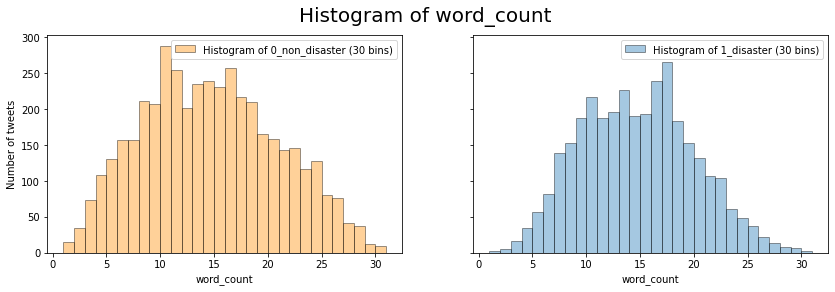

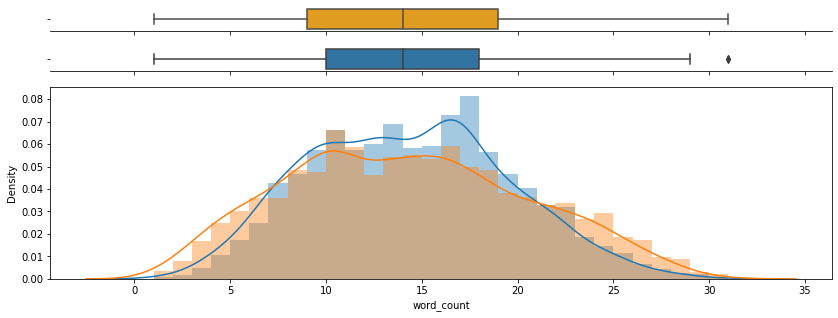

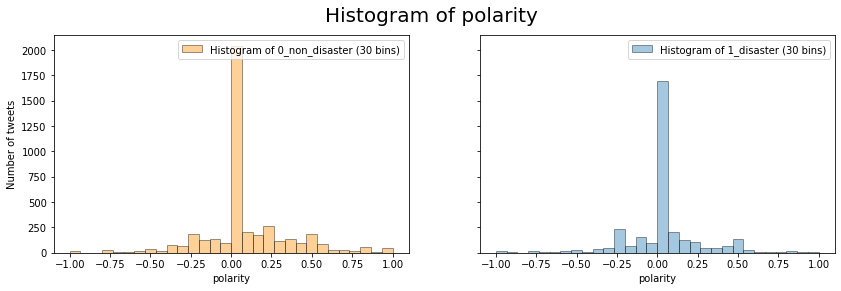

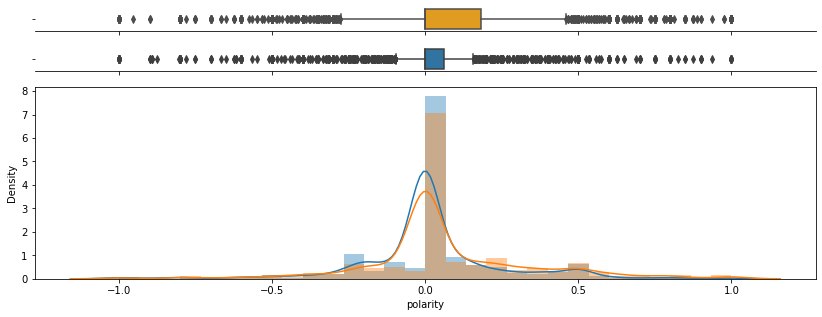

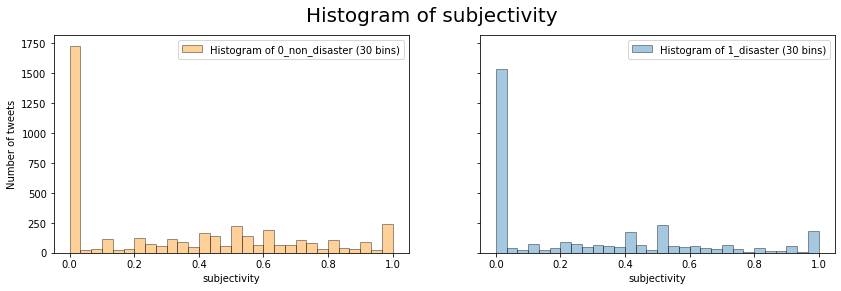

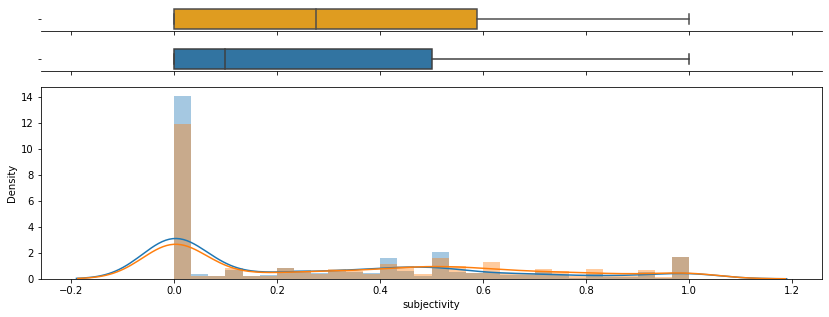

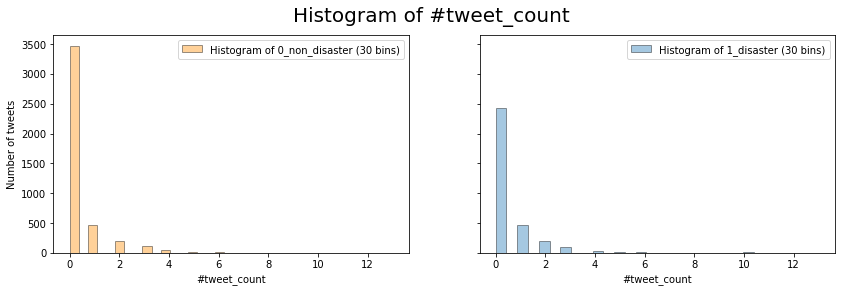

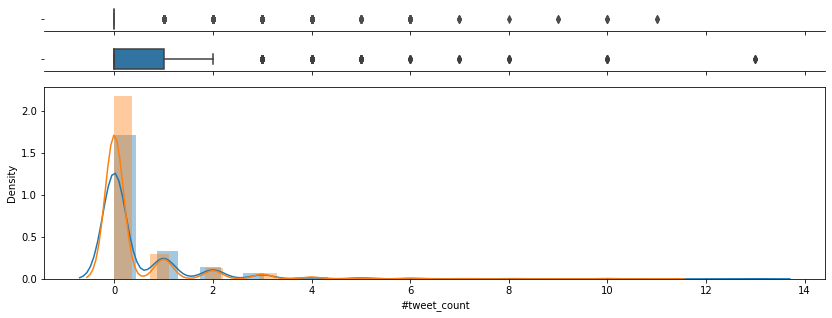

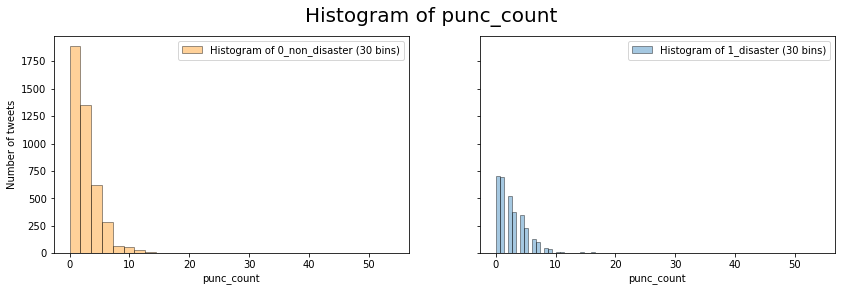

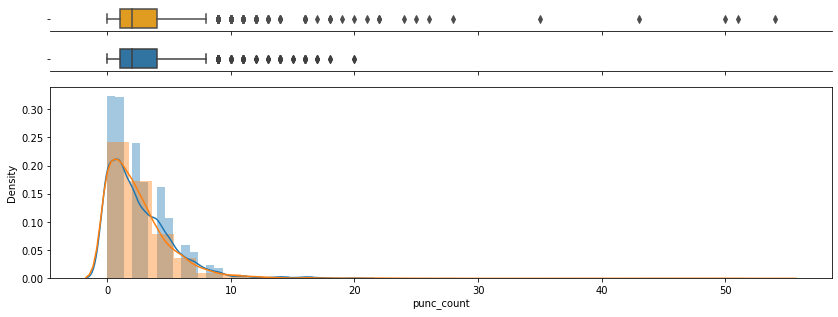

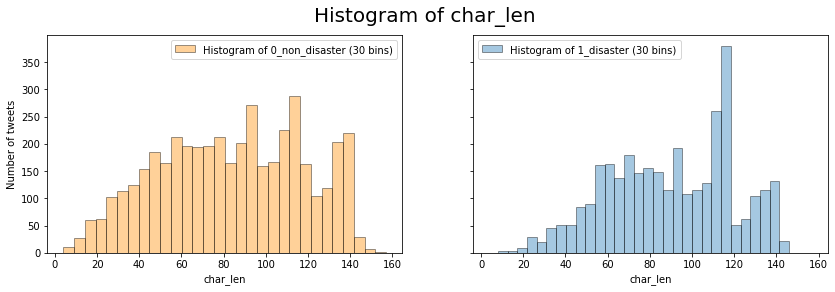

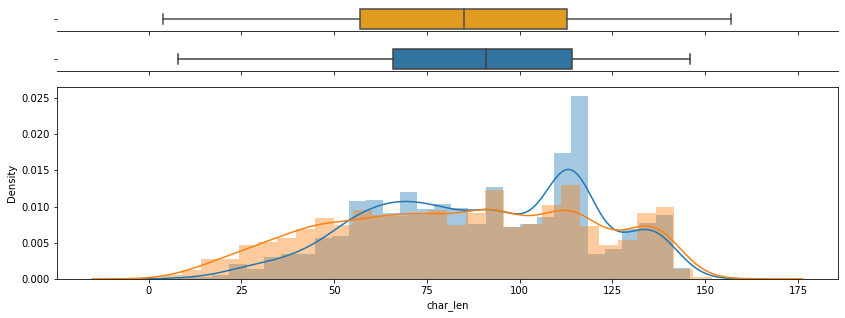

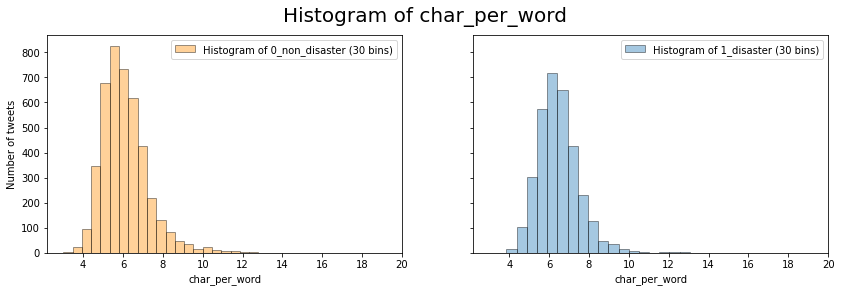

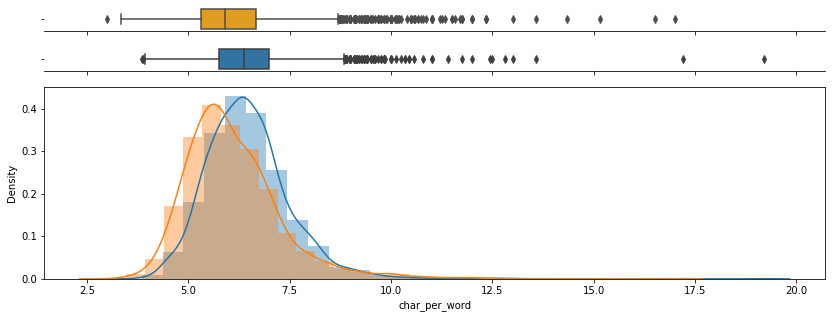

In [12]:
#visualize some shit here
feature_names = ['word_count', 'polarity', 'subjectivity','#tweet_count','punc_count','char_len','char_per_word']
for i in feature_names:
    plot_univariate(i)

In [13]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [14]:
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [15]:
data

,text,target,url_count,text_nourl,word_count,polarity,subjectivity,#tweet_count,punc_count,char_len,char_per_word
0,Our Deeds are the Reason of this #earthquake M...,1.0,0,Our Deeds are the Reason of this #earthquake M...,13,0.00000,0.000000,1,0,69,5.307692
1,Forest fire near La Ronge Sask. Canada,1.0,0,Forest fire near La Ronge Sask. Canada,7,0.10000,0.400000,0,1,38,5.428571
2,All residents asked to 'shelter in place' are ...,1.0,0,All residents asked to 'shelter in place' are ...,22,-0.01875,0.387500,0,3,133,6.045455
3,", people receive #wildfires evacuation orders ...",1.0,0,", people receive #wildfires evacuation orders ...",8,0.00000,0.000000,1,1,60,7.500000
4,Just got sent this photo from Ruby #Alaska as ...,1.0,0,Just got sent this photo from Ruby #Alaska as ...,16,0.00000,0.000000,2,0,88,5.500000
...,...,...,...,...,...,...,...,...,...,...,...
10871,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,0,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,8,0.00000,0.000000,0,0,55,6.875000
10872,Storm in RI worse than last hurricane. My city...,NaN,0,Storm in RI worse than last hurricane. My city...,23,-0.20000,0.333333,0,4,133,5.782609
10873,Green Line derailment in Chicago http://t.co/U...,NaN,1,Green Line derailment in Chicago,5,-0.20000,0.300000,0,0,33,6.600000
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,1,MEG issues Hazardous Weather Outlook (HWO),6,0.60000,0.900000,0,2,43,7.166667


In [16]:
def clean_text(text):
    return ' '.join([t.lower() for t in word_tokenize(text) if t.isalpha() and t.lower() not in stop])
def get_length(text):
    return len(word_tokenize(text))

In [17]:
data['clean']=data['text_nourl'].apply(clean_text)

<AxesSubplot:>

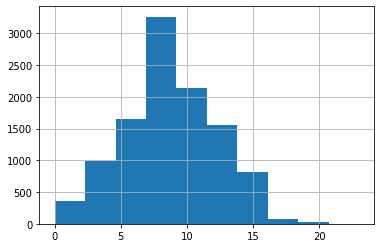

In [18]:
data['clean'].apply(get_length).hist()

In [19]:
data['clean'][2]

'residents asked place notified officers evacuation shelter place orders expected'

In [20]:
sequence_len=15

In [21]:
# load word vectors
#25D  has the best results. 100D and 50D have more overfitting

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = './glove.twitter.27B.25d.txt'
w2v_file = './glove.6B.100d.word2vec.txt'
embedding_dim = 25 # this matches the 100d

glove2word2vec(glove_file, w2v_file)
w2v_model = KeyedVectors.load_word2vec_format(w2v_file)

In [22]:
ntrain=data["target"].notna().sum()

In [23]:
X=data[['word_count','polarity','subjectivity','#tweet_count','punc_count','clean','char_len','char_per_word']][:ntrain]
y=data['target'][:ntrain]

In [24]:
#Text data only
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42
                                            )

In [25]:
X_train_text=pd.DataFrame(X_train['clean'])
X_test_text=pd.DataFrame(X_test['clean'])

In [26]:
# vectorize the text
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=sequence_len)
vectorizer.adapt(data['clean'].values) # I use the full dataset as there could be some words in testing data that are in GLoVE

C:\Users\matth\.conda\envs\sandy-gpu\lib\site-packages\tensorflow_core\python\keras\layers\preprocessing\text_vectorization.py:336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(preprocessed_data.to_list())


In [27]:
X_train_num=X_train.drop('clean',axis=1)
X_test_num=X_test.drop('clean',axis=1)
X_train_vec=vectorizer(X_train_text.values).numpy()
X_test_vec=vectorizer(X_test_text.values).numpy()

In [28]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
word_index

{b'amp': 0,
 b'like': 1,
 b'fire': 2,
 b'get': 3,
 b'new': 4,
 b'via': 5,
 b'news': 6,
 b'people': 7,
 b'one': 8,
 b'would': 9,
 b'video': 10,
 b'emergency': 11,
 b'disaster': 12,
 b'police': 13,
 b'us': 14,
 b'time': 15,
 b'still': 16,
 b'got': 17,
 b'storm': 18,
 b'body': 19,
 b'suicide': 20,
 b'burning': 21,
 b'crash': 22,
 b'first': 23,
 b'rt': 24,
 b'attack': 25,
 b'back': 26,
 b'know': 27,
 b'fires': 28,
 b'california': 29,
 b'see': 30,
 b'going': 31,
 b'day': 32,
 b'buildings': 33,
 b'today': 34,
 b'world': 35,
 b'man': 36,
 b'two': 37,
 b'love': 38,
 b'hiroshima': 39,
 b'bomb': 40,
 b'pm': 41,
 b'nuclear': 42,
 b'full': 43,
 b'go': 44,
 b'youtube': 45,
 b'watch': 46,
 b'dead': 47,
 b'life': 48,
 b'train': 49,
 b'think': 50,
 b'could': 51,
 b'car': 52,
 b'last': 53,
 b'killed': 54,
 b'accident': 55,
 b'say': 56,
 b'good': 57,
 b'war': 58,
 b'u': 59,
 b'make': 60,
 b'gt': 61,
 b'let': 62,
 b'many': 63,
 b'families': 64,
 b'years': 65,
 b'need': 66,
 b'may': 67,
 b'even': 68,
 b'w

In [29]:
# prepare the Embedding matrix
hits = 0
misses = []
embedding_vocab_len = len(voc) + 2 # add 2 entries for padding and OOV (out of vocab)

embedding_matrix = np.zeros((embedding_vocab_len, embedding_dim))
for word, i in word_index.items():
    # lookup in the embedding index
    try:
        word = word.decode('raw_unicode_escape') # handle the b'' issue (not always needed)
        
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector
        hits += 1
    except KeyError:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" (empty words) and "OOV" (out of vocab)
        misses.append(word)

print(f'Converted {hits} words ({len(misses)} misses)')

Converted 14627 words (4594 misses)


In [30]:
misses

['bioterrorism',
 'bioterror',
 'prebreak',
 'soudelor',
 'bestnaijamade',
 'funtenna',
 'disea',
 'udhampur',
 'crematoria',
 'spos',
 'canaanites',
 'Ã¥Ãª',
 'mediterran',
 'inundation',
 'mikeparractor',
 'mhtwfnet',
 'linkury',
 'irandeal',
 'yazidis',
 'summerfate',
 'sinjar',
 'icemoon',
 'djicemoon',
 'viralspell',
 'microlight',
 'usagov',
 'strategicpatience',
 'animalrescue',
 'youngheroesid',
 'wisenews',
 'twia',
 'prophetmuhammad',
 'pantherattack',
 'abbswinston',
 'yycstorm',
 'worldnetdaily',
 'warfighting',
 'sittwe',
 'saddlebrooke',
 'realmandyrain',
 'raynbowaffair',
 'ramag',
 'playthursdays',
 'lulgzimbestpicts',
 'kurtschlichter',
 'kerricktrial',
 'dorret',
 'diamondkesawn',
 'bigamist',
 'apollobrown',
 'Ã¥Ã¨',
 'waimate',
 'votejktid',
 'socialnews',
 'slanglucci',
 'rockyfire',
 'rexyy',
 'realdonaldtrump',
 'otrametlife',
 'oppressions',
 'nickcannon',
 'naved',
 'nasahurricane',
 'metrofmtalk',
 'lonewolffur',
 'livingsafely',
 'liveonline',
 'itunesmusic',

### Going to try 4 networks:
#### 1) Combine Text with non-text data (combined model)
#### 2) Network with ONLY text data (text model)
#### 3) Using CNN on text, then combine with non-text (cnn model)
#### 4) Remove pre-training vectorization (no train model)

In [31]:
# Network structure

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten,Embedding,concatenate,Conv1D,MaxPool1D
from tensorflow.keras.metrics import PrecisionAtRecall as PaR

In [32]:
from tensorflow.keras.initializers import Constant

embedding_layer = Embedding(
    embedding_vocab_len,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix), # our word vectors
    trainable=True # Set True because many missing data in the GLoVE dictionary
)

In [33]:
model_input_1a = Input(shape=(sequence_len,), dtype='int64',name="text")
x = embedding_layer(model_input_1a)
x = Flatten()(x)
x=Model(inputs=model_input_1a, outputs=x)


model_input_1b=Input(shape=(X_train_num.shape[1],),dtype='float32',name='non-text')
y=Dense(12,activation='relu')(model_input_1b)
y=Dense(1,activation='sigmoid')(y)
y=Model(inputs=model_input_1b,outputs=y)

combined=concatenate([x.output,y.output])

z=Dense(36, activation='relu')(combined)
z=Dense(12, activation='relu')(combined)
z=Dense(1, activation='sigmoid')(z)

combined_model=Model(inputs=[x.input,y.input],outputs=z)
combined_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 15)]         0                                            
__________________________________________________________________________________________________
non-text (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 25)       480575      text[0][0]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 12)           96          non-text[0][0]                   
____________________________________________________________________________________________

In [34]:
combined_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('cnn.h5', monitor='val_loss', save_best_only=True)

In [36]:
combined_model.fit(x=[X_train_vec,X_train_num], y=y_train,validation_data=([X_test_vec,X_test_num],y_test),epochs=10,batch_size=64,
               )

Train on 5709 samples, validate on 1904 samples
Epoch 1/10
5709/5709 [==============================] - 2s 276us/sample - loss: 0.7024 - acc: 0.5637 - val_loss: 0.6645 - val_acc: 0.5982
Epoch 2/10
5709/5709 [==============================] - 1s 100us/sample - loss: 0.6381 - acc: 0.6393 - val_loss: 0.6502 - val_acc: 0.6150
Epoch 3/10
5709/5709 [==============================] - 1s 112us/sample - loss: 0.5958 - acc: 0.6961 - val_loss: 0.6338 - val_acc: 0.6408
Epoch 4/10
5709/5709 [==============================] - 1s 130us/sample - loss: 0.5492 - acc: 0.7311 - val_loss: 0.6168 - val_acc: 0.6492
Epoch 5/10
5709/5709 [==============================] - 1s 144us/sample - loss: 0.4936 - acc: 0.7712 - val_loss: 0.6057 - val_acc: 0.6696
Epoch 6/10
5709/5709 [==============================] - 1s 146us/sample - loss: 0.4321 - acc: 0.8147 - val_loss: 0.5895 - val_acc: 0.6996
Epoch 7/10
5709/5709 [==============================] - 1s 142us/sample - loss: 0.3707 - acc: 0.8481 - val_loss: 0.5901 - va

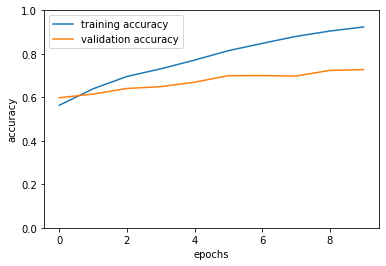

In [37]:
plt.plot(combined_model.history.history['acc'], label='training accuracy')
plt.plot(combined_model.history.history['val_acc'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

In [38]:
model_input_2 = Input(shape=(sequence_len,), dtype='int64',name="text")
x = embedding_layer(model_input_2)
x = Flatten()(x)
x=Dense(36,activation='relu')(x)
x=Dense(12,activation='relu')(x)
x=Dense(1,activation='sigmoid')(x)

text_model = Model(model_input_2, x)
text_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 25)            480575    
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 36)                13536     
_________________________________________________________________
dense_6 (Dense)              (None, 12)                444       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 13        
Total params: 494,568
Trainable params: 494,568
Non-trainable params: 0
_____________________________________________________

In [39]:
text_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [40]:
text_model.fit(x=X_train_vec,y=y_train,validation_data=(X_test_vec,y_test),batch_size=64, epochs=10)

Train on 5709 samples, validate on 1904 samples
Epoch 1/10
5709/5709 [==============================] - 1s 215us/sample - loss: 0.4971 - acc: 0.7578 - val_loss: 0.5695 - val_acc: 0.7300
Epoch 2/10
5709/5709 [==============================] - 1s 94us/sample - loss: 0.2783 - acc: 0.8849 - val_loss: 0.6123 - val_acc: 0.7353
Epoch 3/10
5709/5709 [==============================] - 1s 98us/sample - loss: 0.2001 - acc: 0.9224 - val_loss: 0.6898 - val_acc: 0.7416
Epoch 4/10
5709/5709 [==============================] - 1s 96us/sample - loss: 0.1569 - acc: 0.9413 - val_loss: 0.7166 - val_acc: 0.7311
Epoch 5/10
5709/5709 [==============================] - 1s 96us/sample - loss: 0.1179 - acc: 0.9576 - val_loss: 0.7839 - val_acc: 0.7274
Epoch 6/10
5709/5709 [==============================] - 1s 94us/sample - loss: 0.0975 - acc: 0.9644 - val_loss: 0.8545 - val_acc: 0.7101
Epoch 7/10
5709/5709 [==============================] - 1s 98us/sample - loss: 0.0774 - acc: 0.9714 - val_loss: 0.8894 - val_acc:

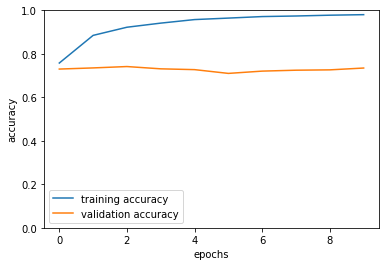

In [41]:
plt.plot(text_model.history.history['acc'], label='training accuracy')
plt.plot(text_model.history.history['val_acc'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

In [42]:
model_input_3a = Input(shape=(sequence_len,), dtype='int64',name="text")
x = embedding_layer(model_input_3a)
x=Conv1D(16,kernel_size=3,strides=1,padding='valid',activation='relu')(x)
x=Conv1D(16,kernel_size=3,strides=1,padding='valid',activation='relu')(x)
x=MaxPool1D(pool_size=2,strides=2)(x)
x = Flatten()(x)

x=Model(inputs=model_input_3a, outputs=x)


model_input_3b=Input(shape=(X_train_num.shape[1],),dtype='float32',name='non-text')
y=Dense(12,activation='relu')(model_input_3b)
y=Dense(1,activation='sigmoid')(y)
y=Model(inputs=model_input_3b,outputs=y)

combined=concatenate([x.output,y.output])

z=Dense(36, activation='relu')(combined)
z=Dense(12, activation='relu')(combined)
z=Dense(1, activation='sigmoid')(z)

cnn_model=Model(inputs=[x.input,y.input],outputs=z)
cnn_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 25)       480575      text[0][0]                       
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 13, 16)       1216        embedding[2][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 11, 16)       784         conv1d[0][0]                     
____________________________________________________________________________________________

In [43]:
cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [44]:
cnn_model.fit(x=[X_train_vec,X_train_num], y=y_train,validation_data=([X_test_vec,X_test_num],y_test),epochs=10,batch_size=64,
            )

Train on 5709 samples, validate on 1904 samples
Epoch 1/10
5709/5709 [==============================] - 3s 572us/sample - loss: 0.5454 - acc: 0.7294 - val_loss: 0.5353 - val_acc: 0.7553
Epoch 2/10
5709/5709 [==============================] - 1s 113us/sample - loss: 0.3395 - acc: 0.8525 - val_loss: 0.5292 - val_acc: 0.7747
Epoch 3/10
5709/5709 [==============================] - 1s 113us/sample - loss: 0.2542 - acc: 0.8935 - val_loss: 0.5454 - val_acc: 0.7721
Epoch 4/10
5709/5709 [==============================] - 1s 114us/sample - loss: 0.1893 - acc: 0.9264 - val_loss: 0.5907 - val_acc: 0.7752
Epoch 5/10
5709/5709 [==============================] - 1s 111us/sample - loss: 0.1437 - acc: 0.9450 - val_loss: 0.6716 - val_acc: 0.7489
Epoch 6/10
5709/5709 [==============================] - 1s 113us/sample - loss: 0.1060 - acc: 0.9636 - val_loss: 0.7339 - val_acc: 0.7542
Epoch 7/10
5709/5709 [==============================] - 1s 112us/sample - loss: 0.0791 - acc: 0.9730 - val_loss: 0.8078 - va

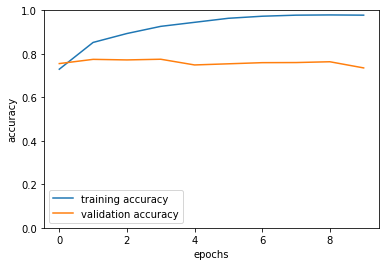

In [45]:
plt.plot(cnn_model.history.history['acc'], label='training accuracy')
plt.plot(cnn_model.history.history['val_acc'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

In [46]:
model_input_4a = Input(shape=(sequence_len,), dtype='int64',name="text")
x = Embedding(input_dim=20000,output_dim=25)(model_input_4a)
x = Flatten()(x)
x=Model(inputs=model_input_4a, outputs=x)


model_input_4b=Input(shape=(X_train_num.shape[1],),dtype='float32',name='non-text')
y=Dense(12,activation='relu')(model_input_4b)
y=Dense(1,activation='sigmoid')(y)
y=Model(inputs=model_input_4b,outputs=y)

combined=concatenate([x.output,y.output])

z=Dense(36, activation='relu')(combined)
z=Dense(12, activation='relu')(combined)
z=Dense(1, activation='sigmoid')(z)

no_train_model=Model(inputs=[x.input,y.input],outputs=z)
no_train_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 15)]         0                                            
__________________________________________________________________________________________________
non-text (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 25)       500000      text[0][0]                       
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 12)           96          non-text[0][0]                   
____________________________________________________________________________________________

In [47]:
no_train_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [48]:
no_train_model.fit(x=[X_train_vec,X_train_num], y=y_train,validation_data=([X_test_vec,X_test_num],y_test),epochs=10,batch_size=64,
               callbacks=[mc])

Train on 5709 samples, validate on 1904 samples
Epoch 1/10
5709/5709 [==============================] - 1s 205us/sample - loss: 0.6630 - acc: 0.5973 - val_loss: 0.6260 - val_acc: 0.6864
Epoch 2/10
5709/5709 [==============================] - ETA: 0s - loss: 0.4949 - acc: 0.822 - 1s 109us/sample - loss: 0.4906 - acc: 0.8245 - val_loss: 0.4804 - val_acc: 0.7952
Epoch 3/10
5709/5709 [==============================] - 1s 110us/sample - loss: 0.2392 - acc: 0.9326 - val_loss: 0.4721 - val_acc: 0.7915
Epoch 4/10
5709/5709 [==============================] - 1s 105us/sample - loss: 0.1176 - acc: 0.9674 - val_loss: 0.4881 - val_acc: 0.7878
Epoch 5/10
5709/5709 [==============================] - 1s 105us/sample - loss: 0.0761 - acc: 0.9771 - val_loss: 0.5265 - val_acc: 0.7757
Epoch 6/10
5709/5709 [==============================] - 1s 102us/sample - loss: 0.0582 - acc: 0.9806 - val_loss: 0.5433 - val_acc: 0.7836
Epoch 7/10
5709/5709 [==============================] - 1s 101us/sample - loss: 0.0501

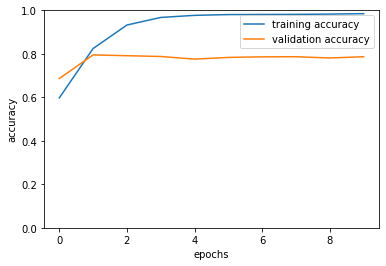

In [49]:
plt.plot(no_train_model.history.history['acc'], label='training accuracy')
plt.plot(no_train_model.history.history['val_acc'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

#### The first 4 models tell me that:
#### 1) Non-text data has some predictive power
#### 2) Convolutions are useful
#### 3) Not using pre-trained vectors increase predictive power

#### Now, I combine all 3 points into the final model below

In [50]:
model_input_5a = Input(shape=(sequence_len,), dtype='int64',name="text")
x = Embedding(input_dim=20000,output_dim=25)(model_input_5a)
x = Conv1D(16, kernel_size=(3),strides=1,padding='valid',activation='relu')(x)
x = Conv1D(16, kernel_size=(3),strides=1,padding='valid',activation='relu')(x)
x = Flatten()(x)
x=Model(inputs=model_input_5a, outputs=x)


model_input_5b=Input(shape=(X_train_num.shape[1],),dtype='float32',name='non-text')
y=Dense(12,activation='relu')(model_input_5b)
y=Dense(1,activation='sigmoid')(y)
y=Model(inputs=model_input_5b,outputs=y)

combined=concatenate([x.output,y.output])

z=Dense(36, activation='relu')(combined)
z=Dense(12, activation='relu')(combined)
z=Dense(1, activation='sigmoid')(z)

final_model=Model(inputs=[x.input,y.input],outputs=z)
final_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 15, 25)       500000      text[0][0]                       
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 13, 16)       1216        embedding_2[0][0]                
__________________________________________________________________________________________________
non-text (InputLayer)           [(None, 7)]          0                                            
___________________________________________________________________________________________

In [51]:
final_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [52]:
final_model.fit(x=[X_train_vec,X_train_num], y=y_train,validation_data=([X_test_vec,X_test_num],y_test),epochs=10,batch_size=64,
               callbacks=[mc])

Train on 5709 samples, validate on 1904 samples
Epoch 1/10
5709/5709 [==============================] - 1s 234us/sample - loss: 0.6497 - acc: 0.6199 - val_loss: 0.5218 - val_acc: 0.7694
Epoch 2/10
5709/5709 [==============================] - 1s 119us/sample - loss: 0.3721 - acc: 0.8445 - val_loss: 0.4704 - val_acc: 0.7810
Epoch 3/10
5709/5709 [==============================] - 1s 110us/sample - loss: 0.1947 - acc: 0.9298 - val_loss: 0.5516 - val_acc: 0.7852
Epoch 4/10
5709/5709 [==============================] - 1s 113us/sample - loss: 0.1115 - acc: 0.9618 - val_loss: 0.6718 - val_acc: 0.7642
Epoch 5/10
5709/5709 [==============================] - 1s 110us/sample - loss: 0.0801 - acc: 0.9741 - val_loss: 0.7292 - val_acc: 0.7479
Epoch 6/10
5709/5709 [==============================] - 1s 158us/sample - loss: 0.0630 - acc: 0.9783 - val_loss: 0.7512 - val_acc: 0.7642
Epoch 7/10
5709/5709 [==============================] - 1s 159us/sample - loss: 0.0523 - acc: 0.9807 - val_loss: 0.8584 - va

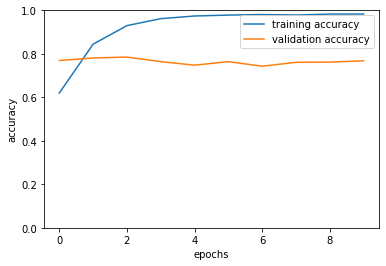

In [53]:
plt.plot(final_model.history.history['acc'], label='training accuracy')
plt.plot(final_model.history.history['val_acc'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

### Best model remains the no_train model, with max validation accuracy reaching 80%!

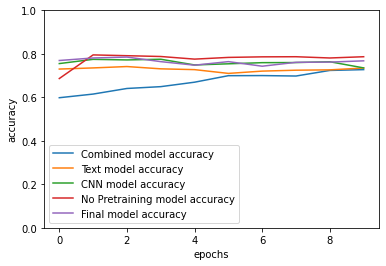

In [54]:
plt.plot(combined_model.history.history['val_acc'], label='Combined model accuracy')
plt.plot(text_model.history.history['val_acc'], label='Text model accuracy')
plt.plot(cnn_model.history.history['val_acc'], label='CNN model accuracy')
plt.plot(no_train_model.history.history['val_acc'], label='No Pretraining model accuracy')
plt.plot(final_model.history.history['val_acc'], label='Final model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

In [55]:
pred=no_train_model.predict([X_test_vec,X_test_num])>=0.5

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test.values,pred)

array([[900, 186],
       [220, 598]], dtype=int64)

In [57]:
no_train_model.save('final_model.h5')

In [79]:
import os
import tensorflow_datasets as tfds
from tensorboard.plugins import projector
import tensorflow as tf

In [77]:
len(word_index)

19221

In [62]:
embedding_layer = Embedding(
    embedding_vocab_len,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix), # our word vectors
    trainable=True # Set True because many missing data in the GLoVE dictionary
)

In [ ]:
word_index_plot=[]

for word, i in word_index.items():
    # lookup in the embedding index
    try:
        word = word.decode('raw_unicode_escape') # handle the b'' issue (not always needed)
        
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector

In [84]:
log_dir='/logs/text-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in word_index.keys():
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown"
  for unknown in range(1, len(word_index) - len(word_index.keys())):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(combined_model.layers[2].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [83]:
combined_model.layers[2]

In [88]:
%tensorboard --logdir /logs/text-example/

Reusing TensorBoard on port 6006 (pid 14772), started 0:01:42 ago. (Use '!kill 14772' to kill it.)

In [86]:
%load_ext tensorboard